# To-Do - List
1. Condomínio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from app.preprocess import train_preprocessor
from app.regression import train_regressor
from app.optimization import optimize_regressor

from src.model.preprocessing import get_preprocessor
from src.model.regressor import get_regressor

from src.base.commons import dump_json, load_json, dump_yaml, load_yaml, load_pickle
from src.optimizer import gaussian_process_optimization

In [2]:

# Train the preprocess pipeline
train_preprocessor(extract_data=False)

# Otimizar parametros
optimize_regressor()

# train regressor model
train_regressor()

2022-06-19 11:25:02,620 [INFO] FUNCTION: train_preprocessor
2022-06-19 11:25:02,625 [INFO] Getting information from yamls
2022-06-19 11:25:02,669 [INFO] Contructing datasets from raw database
2022-06-19 11:25:03,723 [INFO] Building features
2022-06-19 11:25:03,724 [INFO] Build features related to state type
2022-06-19 11:25:03,785 [INFO] Build features related to date
2022-06-19 11:25:03,854 [INFO] Build features related to latitude and longitude
2022-06-19 11:25:03,870 [INFO] Build features related to distances
2022-06-19 11:25:03,895 [INFO] Splitting in train and test
2022-06-19 11:25:03,946 [INFO] Train preprocessor
2022-06-19 11:25:06,289 [INFO] Tranforming features
2022-06-19 11:25:08,868 [INFO] Exporting splitted dataset
2022-06-19 11:25:10,221 [INFO] Export preprocessor artifacts


# Predictions

In [2]:
preprocessor = get_preprocessor()
regressor = get_regressor()

In [7]:
fake_data = {
    'type': 'HOME',
    'n_parking_spaces': 4,
    'n_bathrooms': 1,
    'n_bedrooms': 2,
    'area': 253,
    'n_suites': 0,
    'neighborhood': 'São João',
    'n_floors': np.nan,
    'units_on_floor': 0,
    'state': 'MG',
    'city': 'Poços de Caldas',
    'street': None,
    'longitude': np.nan,
    'latitude': np.nan,
    #'condo_fee': 800.0,
    'iptu': 625.0,
    'search_date': '2022-06-17'
}

from src.model.preprocessing import preprocess_transform

x = preprocess_transform(fake_data)

regressor.predict(x)

2022-06-19 11:38:35,840 [INFO] Build features related to state type
2022-06-19 11:38:35,848 [INFO] Build features related to date
2022-06-19 11:38:35,860 [INFO] Build features related to latitude and longitude
2022-06-19 11:38:35,869 [INFO] Build features related to distances


array([575313.75], dtype=float32)

# Testes


In [13]:
from src.model.features import build_features
from src.model.data import (
    get_train_dataset,
    add_external_data
)

In [14]:
extract_data = False

data_config = load_yaml(filename="config/filepaths.yaml")
features_config = load_yaml(filename="config/features.yaml")

raw_scrapped_features, y = get_train_dataset(data_config, extract_data=extract_data)
raw_scrapped_features = add_external_data(raw_scrapped_features, data_config)

X = build_features(raw_scrapped_features)

2022-06-19 08:49:29,311 [INFO] Build features related to state type
2022-06-19 08:49:29,360 [INFO] Build features related to date
2022-06-19 08:49:29,420 [INFO] Build features related to latitude and longitude
2022-06-19 08:49:29,432 [INFO] Build features related to distances


In [18]:
pd.options.display.max_columns = None

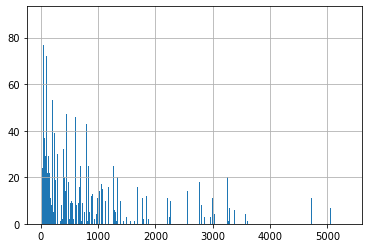

In [54]:
temp = X['iptu'].replace(0,np.nan)
temp[temp>10].hist(bins=400)

# plt.xlim([0,5000])
plt.show()

In [52]:
temp.quantile([0.05,0.95])

0.05      43.0
0.95    3000.0
Name: iptu, dtype: float64

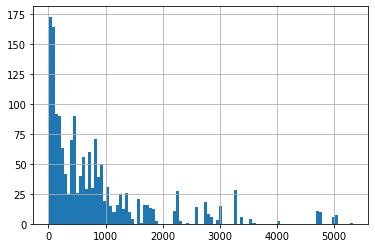

In [26]:
X['iptu'].replace(0,np.nan).hist(bins=100)

plt.show()

In [19]:
X.head(2)

,id,search_id,id_zap,type,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_floors,units_on_floor,n_suites,state,city,neighborhood,street,longitude,latitude,condo_fee,iptu,resale,buildings,plan_only,search_date,neighbor_region,neighbor_latitude,neighbor_longitude,pop_2000,pop_2010,pop_2022_proj,pct_domicilios_por_sal_min_0,pct_domicilios_por_sal_min_0_0.5,pct_domicilios_por_sal_min_0.5_1,pct_domicilios_por_sal_min_1_2,pct_domicilios_por_sal_min_2_5,pct_domicilios_por_sal_min_5_10,pct_domicilios_por_sal_min_10_20,pct_domicilios_por_sal_min_20_inf,neighbor_avg_income,taxa_alfabetizacao_bairro,type_APARTMENT,type_HOME,type_ALLOTMENT_LAND,type_COUNTRY,time_delta,year,month,day,dist_manh,dist_square,dist
0,1,2503300374__2021_06_04_00_23_37,2503300374,HOME,2.0,3.0,3.0,100.0,NaN,0,1.0,MG,Poços de Caldas,jardim_das_hortensias,None,-46.539132,-21.808408,NaN,NaN,0,0,0,2021-06-04,Região Urbana Homogênea XX,-21.808408,-46.539132,527.0,2534.0,4942.0,0.001229,0.028256,0.079853,0.37715,0.321867,0.142506,0.028256,0.020885,1836.92,99.1,0.0,1.0,0.0,0.0,154,2021,6,4,0.046343,0.001119,0.033459
1,4,2500808474__2021_06_04_00_23_40,2500808474,HOME,2.0,3.0,2.0,130.0,NaN,0,2.0,MG,Poços de Caldas,jardim_amaryllis,None,-46.541238,-21.805235,0.0,0.0,0,0,0,2021-06-04,Região Urbana Homogênea XX,-21.805235,-46.541238,527.0,2534.0,4942.0,0.001229,0.028256,0.079853,0.37715,0.321867,0.142506,0.028256,0.020885,1836.92,99.1,0.0,1.0,0.0,0.0,154,2021,6,4,0.041064,0.000899,0.029991
